# GAUSSIAN NOISE
### Gradient Descent

In [419]:
import numpy as np
import matplotlib.pyplot as plt

In [420]:
def backtracking_vander(f, grad_f, x,A, b, l=1):
    alpha = 1
    c = 0.8
    tau = 0.25

    while f(x - alpha * grad_f(x,A,b,l), A, b, l) > f(x, A, b, l) - c * alpha * np.linalg.norm(grad_f(x,A,b,l)) ** 2:
        alpha = tau * alpha

        if alpha < 1e-3:
            break
    return alpha
    
def GD_vander(f, grad_f, x0, tolf, tolx, kmax, A, b, l=1):
    #initialization
    a=1 #stepsize
    f_val=np.zeros((kmax,))
    err_val=np.zeros((kmax,))
    #if(x_val.shape)
    x_val=[]
    x_val.append(x0)
    #iterations
    k=0
    conditions=True
    while (conditions):
        #update a
        if(k!=0):
            a=backtracking_vander(f, grad_f, x, A, b, l)
        #update x
        x=x0-a*grad_f(x0, A, b, l)
        #store values
        #f_val[k]=f(x, A, b, l)
        #err_val[k]=np.linalg.norm(grad_f(x, A, b, l))
        x_val.append(x)
        #update k
        k+=1
        #update conditions
        stopcond1=np.linalg.norm(grad_f(x, A, b, l)) > tolf*np.linalg.norm(grad_f(x_val[0], A, b, l)) 
        stopcond2=np.linalg.norm(x-x0) > tolx*np.linalg.norm(x_val[0])
        conditions=k<kmax-1 and stopcond1 and stopcond2
        #restart
        x0=x
    #truncate vectors -> not mandatory (visualization purposes in case of convergence in k)
    f_val=f_val[:k]
    err_val=err_val[:k]
    return x

In [421]:

def vandermore(X, K):
    N=X.shape[0]
    phi=np.zeros((N,K))
    for j in range(K):
        phi[:,j]=X**j
    return phi

create dataset X_test

Text(0.5, 1.0, 'Datapoints')

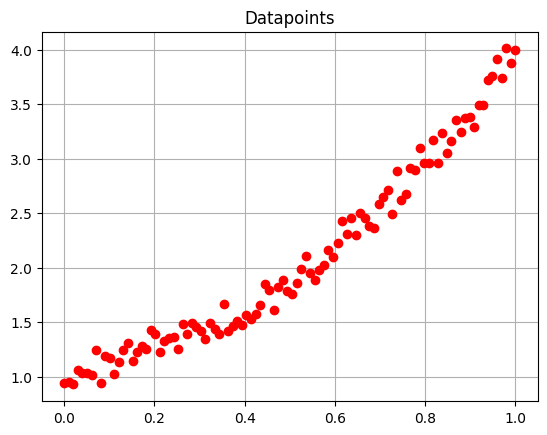

In [422]:
#create test problem
N=100 #n. of datapoints
K=4

a=0
b=1
#define true solution
theta_true=np.ones((K,))
X=np.linspace(a,b,N) #100 values equispaced from 0 to 1
#define Y such that theta_true is the solution of
#Phi(X)*theta=Y
phi=vandermore(X, K)
Y = phi @ theta_true 

#corrupt Y with noise (standard normal distribution with sigma=0.1)
sigma=0.1
Y=Y+sigma*np.random.normal(0,1,Y.shape)

#plot X against Y with red dots
plt.plot(X,Y, "o", color="red")
plt.grid()
plt.title("Datapoints")


# MLE

In [423]:
def l_mle(x,A,b, l=1):
    res=(1/2)*np.linalg.norm(A@x-b)**2
    return res
def grad_l_mle(x,A,b, l=1):
    return (A@x-b).T@A


(4,)
(100, 4)


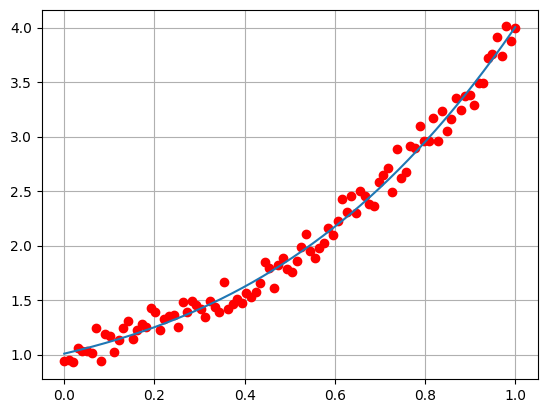

In [424]:
#given x and y compute a solution theta_mle using Gradient descent
w0=np.ones((K,))
theta_mle=GD_vander(l_mle, grad_l_mle, w0, 1e-5, 1e-5, 50, A=phi, b=Y)
print(theta_mle.shape)


#plot f_theta(X)
XX=np.linspace(a,b,1000)
YY=vandermore(XX,K)@theta_mle
plt.plot(X,Y, "ro")
print(phi.shape)
#f_theta=phi@theta_mle
plt.plot(XX,YY)
plt.grid()



In [425]:
#test error funciton with mean squared error
def test_Error(theta, phi, Y):
    result=np.linalg.norm(phi@theta-Y)**2
    N=Y.shape[0]
    return result/N

In [426]:
#a function that takes (X,Y) and K and returns theta_mle
def fit_mle(D,K):#D=(X,Y)
    x,y=D
    phi=vandermore(x,K)
    w0=np.ones((K,))
    theta_mle= GD_vander(l_mle, grad_l_mle, w0, 1e-3, 1e-3, 50, A=phi, b=y)
    return theta_mle

## different values of K

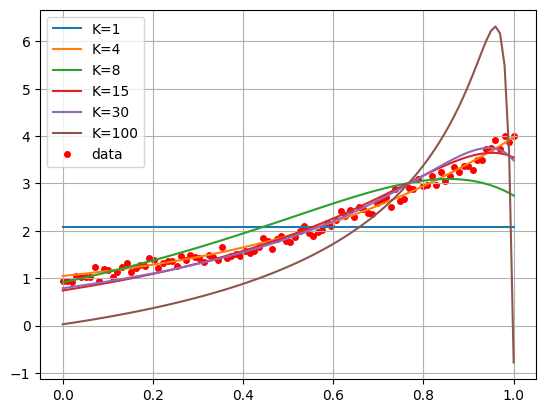

In [427]:
#we now want to UNDERFIT the model
#X and Y are fixed
#pretend to not know K -> we guess it
k_values=[1,4,8,15,30,100]
#solve MLE with difqferent K
for K_trial in k_values:
    phi_trial=vandermore(X, K_trial)
    w0=np.ones((K_trial,))
    theta_mle_t=GD_vander(l_mle, grad_l_mle, w0, 1e-3, 1e-3, 50, A=phi_trial, b=Y)
    plt.plot(X, phi_trial@theta_mle_t, label="K="+str(K_trial), zorder=2)

#plot new model as before with dataset
plt.plot(X,Y, "ro", markersize=4, label="data", zorder=1)
plt.legend()
plt.grid()

Test and train error for different values of K

Text(0, 0.5, 'error')

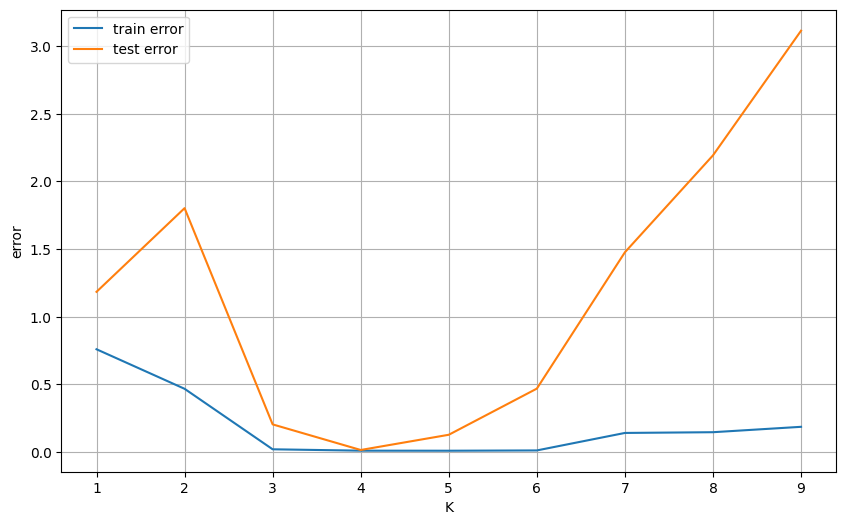

In [428]:
N_test=50
X_test=np.linspace(a,b,N_test)
#calculate Y_test as before, witj different K
test_error_mle=[]
train_error_mle=[]
k_values=np.arange(1,10)
for K_trial in k_values:
    theta_true=np.ones((K_trial,))
    Y_test=vandermore(X_test,K_trial)@theta_true
    Y_test=Y_test+sigma*np.random.normal(0,1,Y_test.shape)
    theta_train=fit_mle((X,Y), K_trial)
    phi_test=vandermore(X_test, K_trial)
    phi_train=vandermore(X, K_trial)
    test_error_mle.append(test_Error(theta_train, phi_test, Y_test))
    train_error_mle.append(test_Error(theta_train, phi_train, Y))

        
#plot test and train errors
plt.figure(figsize=(10,6))
plt.plot(k_values, train_error_mle, label="train error")
plt.plot(k_values, test_error_mle, label="test error")
plt.legend()
plt.grid()
plt.xlabel("K")
plt.ylabel("error")

# MAP 


In [429]:
def l_map(x,A,b, l):
    res=(1/2)*(np.linalg.norm((A@x-b))**2 + l*np.linalg.norm(x)**2)
    return res

def grad_l_map(x,A,b, l):
    return (A@x-b).T@A + l*x
#numpy identity matyrix
def fit_map(D, K, lam):
    x,y=D
    phi=vandermore(x,K)
    w0=np.ones((K,))
    theta_map=GD_vander(l_map, grad_l_map, w0, 1e-3, 1e-3, 50, A=phi, b=y, l=lam)
    return theta_map

Text(0.5, 0.98, 'MAP for different K and lambda')

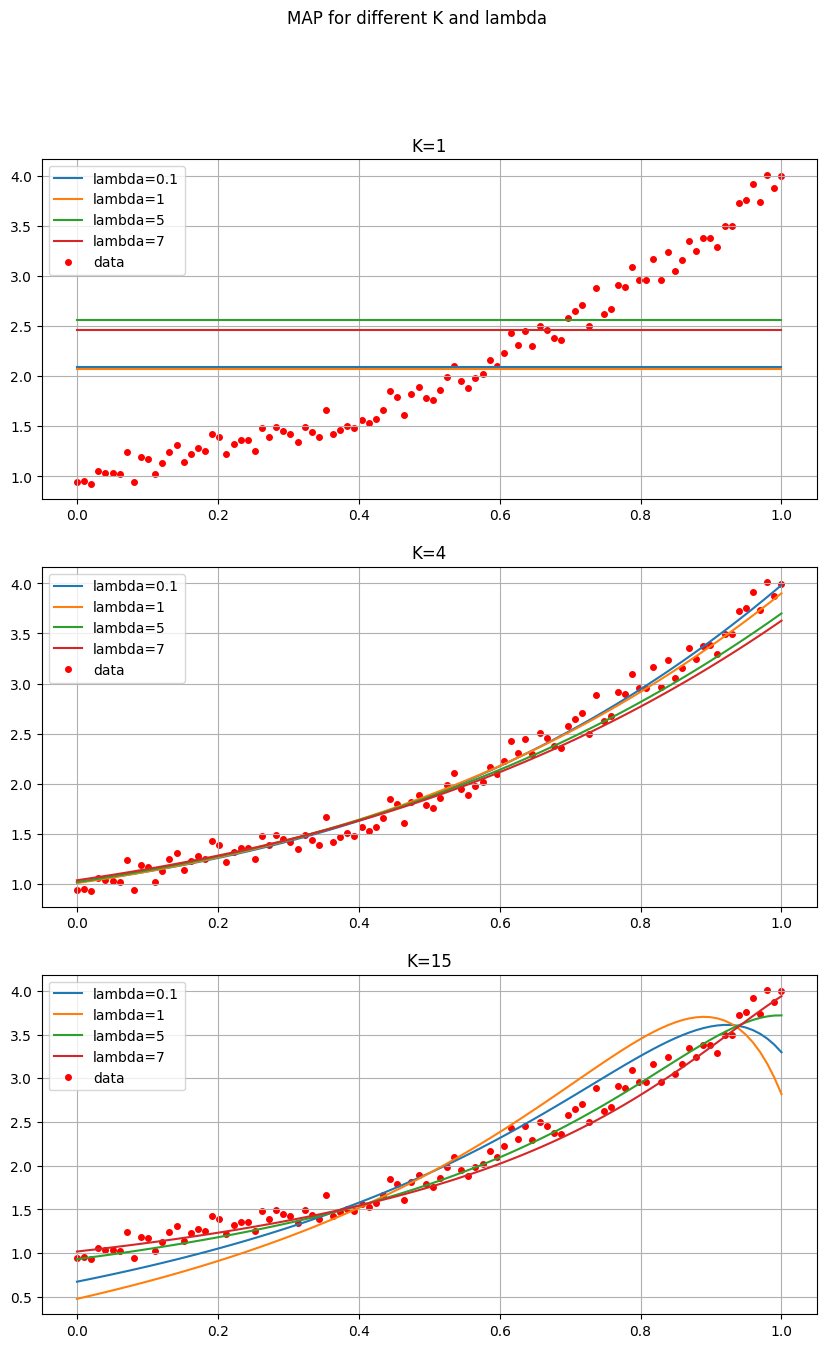

In [430]:
l_val=[0.1,1,5,7]
k_val=[1,4,15]
#solve MAP with different lambda and k, for each k make a subplot
plt.figure(figsize=(10,15))
i=0
for K_trial in k_val:
    i+=1
    for l_trial in l_val:
        phi_trial=vandermore(X, K_trial)
        theta_map=fit_map((X,Y), K_trial, l_trial)
        plt.subplot(3,1, i)
        plt.plot(X, phi_trial@theta_map, label="lambda="+str(l_trial))
    plt.plot(X,Y, "ro", markersize=4, label="data", zorder=1)
    plt.grid()
    plt.legend()
    plt.title("K="+str(K_trial))
plt.suptitle("MAP for different K and lambda")

For K being <b>way greater</b> than the correct degree of the polynomial (>>4), compute the MLE and MAP<br>
solution. Compare the test error of the two, for different values of λ (in the case of MAP).

Text(0.5, 0.98, 'K=1000')

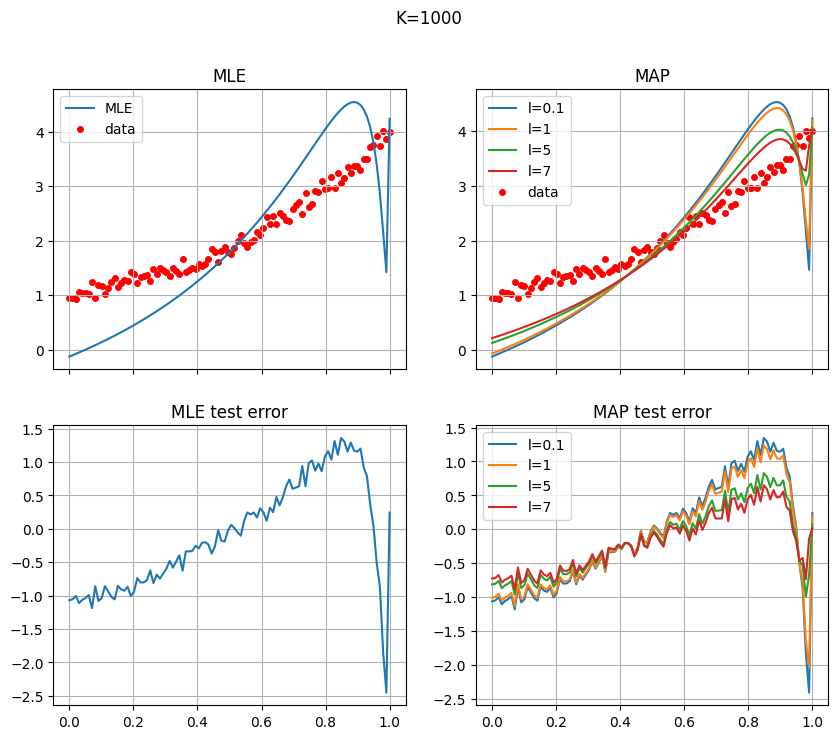

In [431]:
K=1000
phi=vandermore(X, K)
theta_MLE=fit_mle((X,Y), K)
mle_error=test_Error(theta_MLE, phi, Y)
fig, axes=plt.subplots(nrows=2,ncols=2, figsize=(10,8), sharex=True, sharey=False)
#axes[0,0].title("MLE")
axes[0,0].plot(X, phi@theta_MLE, label="MLE", zorder=2)
axes[0,0].plot(X,Y, "ro", markersize=4, label="data", zorder=1)
axes[0,0].legend()
axes[0,0].grid()
#axes[1,0].title("MLE error")
axes[1,0].plot(X, phi@theta_MLE-Y, label="MLE error")

for l in l_val:
    theta_map=fit_map((X,Y), K, l)
    map_error=test_Error(theta_map, phi, Y)
    #axes[0,1].title("MAP")
    axes[0,1].plot(X, phi@theta_map, label="l="+str(l), zorder=2)
    #axes[0,1].title("MAP error")
    axes[1,1].plot(X, phi@theta_map-Y, label="l="+str(l))
axes[0,1].plot(X,Y, "ro", markersize=4, label="data", zorder=1)
axes[0,1].legend()
axes[0,1].grid()
axes[1,1].grid()
axes[1,1].legend()
axes[1,0].grid()
plt.subplot(2,2,1)
plt.title("MLE")
plt.subplot(2,2,2)
plt.title("MAP")
plt.subplot(2,2,3)
plt.title("MLE test error")
plt.subplot(2,2,4)
plt.title("MAP test error")
plt.suptitle("K="+str(K))



Define $Err(\theta)=\frac{||\theta-\theta_{true}||}{||\theta_{true}||}$, then compare Err($\theta_{MLE}$) and Err($\theta_{MAP}$) for different values of K and λ.

In [432]:
def err(theta, theta_true):
    if(theta_true.shape[0]<theta.shape[0]):
        theta_true=np.concatenate((theta_true, np.zeros(theta.shape[0]-theta_true.shape[0])))
    err=np.linalg.norm(theta-theta_true)
    err=err/np.linalg.norm(theta_true)
    return err
K=4
phi=vandermore(X, K)
theta_true_mle=fit_mle((X,Y), K)
theta_true_map=fit_map((X,Y), K, 0)
k_val=[30,50,70]
l_val=[0,1,5,15,40]
for k in k_val:
    theta_mle=fit_mle((X,Y), k)
    print("k=", k)
    print(" MLE error=", err(theta_mle, theta_true_mle))
    print(" MAP error")
    for l in l_val:
        theta_map=fit_map((X,Y), k, l)
        print(" l=",l,"->", err(theta_map, theta_true_map))
    
    print("")

k= 30
 MLE error= 0.4332843658452264
 MAP error
 l= 0 -> 0.4332843658452264
 l= 1 -> 0.3867015041463978
 l= 5 -> 0.451666305778417
 l= 15 -> 0.48431392082495467
 l= 40 -> 0.5286471863737072

k= 50
 MLE error= 0.3607430153180163
 MAP error
 l= 0 -> 0.3607430153180163
 l= 1 -> 0.3598684328169518
 l= 5 -> 0.4373915125320844
 l= 15 -> 0.7552746860276803
 l= 40 -> 0.5639503218032748

k= 70
 MLE error= 0.34743160153497393
 MAP error
 l= 0 -> 0.34743160153497393
 l= 1 -> 0.37030383116688975
 l= 5 -> 0.7500700837765717
 l= 15 -> 0.8604749323357245
 l= 40 -> 0.5881498771002301

